In [8]:
import torch
import torchvision.transforms.v2 as v2
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn.functional as F
#from collections import defaultdict, deque
import numpy as np

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, image):
        image2 = torch.clone(image)
        if len(image2.shape) == 4:
            # batched
            image2 = image2.permute(1, 0, 2, 3)
        for t, m, s in zip(image2, self.mean, self.std):
            t.mul_(s).add_(m)
        return image2.permute(1, 0, 2, 3)
    
norm = v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
unnorm = UnNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

class TorchPCA(object):

    def __init__(self, n_components):
        self.n_components = n_components

    def fit(self, X):
        self.mean_ = X.mean(dim=0)
        unbiased = X - self.mean_.unsqueeze(0)
        U, S, V = torch.pca_lowrank(unbiased, q=self.n_components, center=False, niter=4)
        self.components_ = V.T
        self.singular_values_ = S
        return self

    def transform(self, X):
        t0 = X - self.mean_.unsqueeze(0)
        projected = t0 @ self.components_.T
        return projected


def pca(image_feats_list, dim=3, fit_pca=None, max_samples=None):
    device = image_feats_list[0].device

    def flatten(tensor, target_size=None):
        if target_size is not None and fit_pca is None:
            tensor = F.interpolate(tensor, (target_size, target_size), mode="bilinear")
        B, C, H, W = tensor.shape
        return tensor.permute(1, 0, 2, 3).reshape(C, B * H * W).permute(1, 0).detach().cpu()

    if len(image_feats_list) > 1 and fit_pca is None:
        target_size = image_feats_list[0].shape[2]
    else:
        target_size = None

    flattened_feats = []
    for feats in image_feats_list:
        flattened_feats.append(flatten(feats, target_size))
    x = torch.cat(flattened_feats, dim=0)

    # Subsample the data if max_samples is set and the number of samples exceeds max_samples
    if max_samples is not None and x.shape[0] > max_samples:
        indices = torch.randperm(x.shape[0])[:max_samples]
        x = x[indices]

    if fit_pca is None:
        fit_pca = TorchPCA(n_components=dim).fit(x)

    reduced_feats = []
    for feats in image_feats_list:
        x_red = fit_pca.transform(flatten(feats))
        if isinstance(x_red, np.ndarray):
            x_red = torch.from_numpy(x_red)
        x_red -= x_red.min(dim=0, keepdim=True).values
        x_red /= x_red.max(dim=0, keepdim=True).values
        B, C, H, W = feats.shape
        reduced_feats.append(x_red.reshape(B, H, W, dim).permute(0, 3, 1, 2).to(device))

    return reduced_feats, fit_pca

from pytorch_lightning import seed_everything

def _remove_axes(ax):
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.set_xticks([])
    ax.set_yticks([])


def remove_axes(axes):
    if len(axes.shape) == 2:
        for ax1 in axes:
            for ax in ax1:
                _remove_axes(ax)
    else:
        for ax in axes:
            _remove_axes(ax)

def plot_feats(image, lr, hr):
    assert len(image.shape) == len(lr.shape) == len(hr.shape) == 3
    seed_everything(0)
    [lr_feats_pca, hr_feats_pca], _ = pca([lr.unsqueeze(0), hr.unsqueeze(0)])
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image.permute(1,2,0).detach().cpu())
    ax[0].set_title("Image")
    ax[1].imshow(lr_feats_pca[0].permute(1,2,0).detach().cpu())
    ax[1].set_title("Original Features")
    ax[2].imshow(hr_feats_pca[0].permute(1,2,0).detach().cpu())
    ax[2].set_title("Upsampled Features")
    remove_axes(ax)
    plt.show()

from concurrent.futures import ProcessPoolExecutor


In [9]:
input_size = 224
image_path = "/data/NWPU-RESISC45/airplane/airplane_301.jpg"
image_path = "/data/NWPU-RESISC45/tennis_court/tennis_court_130.jpg"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_norm = True
image = Image.open(image_path).convert("RGB")
transform = v2.Compose([
    v2.Resize(input_size),
    v2.CenterCrop((input_size, input_size))
])
image = transform(image)

In [10]:
small_img = v2.Resize(16)(image)

In [11]:
src = small_img.copy()
ref = image.copy()

reference = np.array(ref)
source_image_upsampled = src.resize(ref.size, Image.BILINEAR)
source_upsampled = np.array(source_image_upsampled)

scale = src.width / ref.width
radius = 2
diameter = 2 * radius + 1
step = int(np.ceil(1 / scale))
padding = radius * step
sigma_spatial = 2.5
sigma_range = np.std(reference)

reference = np.pad(reference, ((padding, padding), (padding, padding), (0, 0)), 'symmetric').astype(np.float32)
source_upsampled = np.pad(source_upsampled, ((padding, padding), (padding, padding), (0, 0)), 'symmetric').astype(np.float32)

# Spatial Gaussian function.
x, y = np.meshgrid(np.arange(diameter) - radius, np.arange(diameter) - radius)
kernel_spatial = np.exp(-1.0 * (x**2 + y**2) /  (2 * sigma_spatial**2))
kernel_spatial = np.repeat(kernel_spatial, 3).reshape(-1, 3)

# Lookup table for range kernel.
lut_range = np.exp(-1.0 * np.arange(256)**2 / (2 * sigma_range**2))

def process_row(y):
    result = np.zeros((ref.width, 3))
    y += padding
    for x in range(padding, reference.shape[1] - padding):
        I_p = reference[y, x]
        patch_reference = reference[y - padding:y + padding + 1:step, x - padding:x + padding + 1:step].reshape(-1, 3)
        patch_source_upsampled = source_upsampled[y - padding:y + padding + 1:step, x - padding:x + padding + 1:step].reshape(-1, 3)

        kernel_range = lut_range[np.abs(patch_reference - I_p).astype(int)]
        weight = kernel_range * kernel_spatial
        k_p = weight.sum(axis=0)
        result[x - padding] = np.round(np.sum(weight * patch_source_upsampled, axis=0) / k_p)

    return result

executor = ProcessPoolExecutor()
result = executor.map(process_row, range(ref.height))
executor.shutdown(True)
jbu_img = Image.fromarray(np.array(list(result)).astype(np.uint8))   

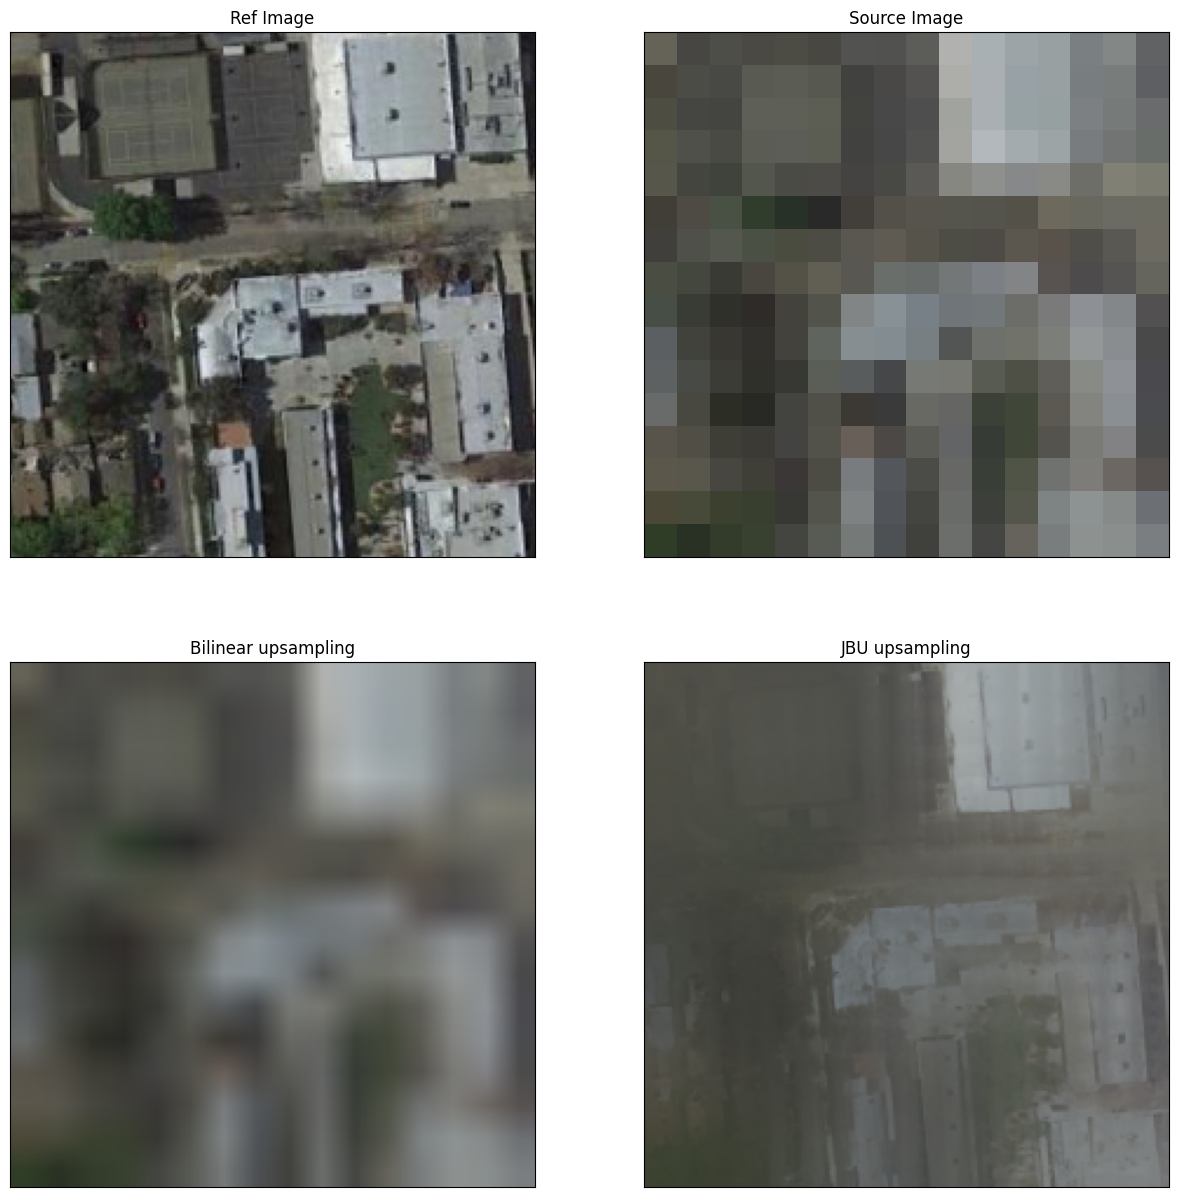

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax[0,0].imshow(image)
ax[0,0].set_title("Ref Image")
#ax[0,1].imshow(lr_feats_pca[0].permute(1,2,0).detach().cpu())
ax[0,1].imshow(small_img)
ax[0,1].set_title("Source Image")
ax[1,0].imshow(small_img.resize(image.size, Image.BILINEAR))
ax[1,0].set_title("Bilinear upsampling")
ax[1,1].imshow(jbu_img)
ax[1,1].set_title("JBU upsampling")
remove_axes(ax)
plt.show()

In [13]:
input_size = 224
image_path = "/data/NWPU-RESISC45/airplane/airplane_301.jpg"
image_path = "/data/NWPU-RESISC45/tennis_court/tennis_court_130.jpg"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_norm = True
image = Image.open(image_path).convert("RGB")
transform = v2.Compose([
    v2.Resize(input_size),
    v2.CenterCrop((input_size, input_size))
])
image = transform(image)

In [14]:
import numpy as np
image_tensor = norm(v2.functional.to_tensor(image)).unsqueeze(0).to(device)
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14').to(device)
h = image_tensor.shape[2] // 14
w = image_tensor.shape[3] // 14
lr_feats = model.forward_features(image_tensor)["x_norm_patchtokens"].reshape(-1, h, w, 384)
lr_feats = lr_feats[0].permute(2,0,1).detach().cpu()
print(lr_feats.shape)
#plot_feats(unnorm(image_tensor)[0], lr_feats[0], lr_feats[0])
seed_everything(0)
#[lr_feats_pca], _ = pca([lr_feats[0].unsqueeze(0)])
#features_pca = lr_feats_pca[0].permute(1,2,0).detach().cpu()
#print(features_pca.shape)
#lr_feat_img = lr_feats[0].permute(1,2,0)

/d/pfournie/dl_toolbox/venv/lib/python3.8/site-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(
Using cache found in /d/pfournie/.cache/torch/hub/facebookresearch_dinov2_main
/d/pfournie/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/d/pfournie/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/d/pfournie/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Seed set to 0


torch.Size([384, 16, 16])


0

In [15]:
ref = image.copy()
reference = np.array(ref)

source_image_upsampled = v2.Resize(224)(lr_feats).permute(1,2,0)
source_upsampled = np.array(source_image_upsampled)

NB_CHANNELS = 384

scale = 16 / 224
radius = 2
diameter = 2 * radius + 1
step = int(np.ceil(1 / scale))
padding = radius * step
sigma_spatial = 2.5
sigma_range = np.std(reference)

reference = np.pad(reference, ((padding, padding), (padding, padding), (0, 0)), 'symmetric').astype(np.float32)
source_upsampled = np.pad(source_upsampled, ((padding, padding), (padding, padding), (0, 0)), 'symmetric').astype(np.float32)

# Spatial Gaussian function.
x, y = np.meshgrid(np.arange(diameter) - radius, np.arange(diameter) - radius)
kernel_spatial = np.exp(-1.0 * (x**2 + y**2) /  (2 * sigma_spatial**2))
#kernel_spatial = np.repeat(kernel_spatial, 3).reshape(-1, 3)
kernel_spatial = np.reshape(-1,1)

# Lookup table for range kernel.
lut_range = np.exp(-1.0 * np.arange(256)**2 / (2 * sigma_range**2))

def process_row(y):
    result = np.zeros((ref.width, NB_CHANNELS))
    y += padding
    for x in range(padding, reference.shape[1] - padding):
        I_p = reference[y, x]
        patch_reference = reference[y - padding:y + padding + 1:step, x - padding:x + padding + 1:step].reshape(-1, 3)
        patch_source_upsampled = source_upsampled[y - padding:y + padding + 1:step, x - padding:x + padding + 1:step].reshape(-1, NB_CHANNELS)

        kernel_range = lut_range[np.abs(patch_reference - I_p).astype(int)]
        norm = np.linalg.norm(patch_reference-I_p, axis=1, keepdims=True)
        kernel_range = np.exp(-1.0 * norm**2 / (2 * sigma_range**2))
        weight = kernel_range * kernel_spatial
        prod = weight * patch_source_upsampled
        k_p = weight.sum(axis=0)
        res = np.round(np.sum(weight * patch_source_upsampled, axis=0) / k_p)
        result[x - padding] = res
    return result

executor = ProcessPoolExecutor()
result = executor.map(process_row, range(ref.height))
executor.shutdown(True)
hr_feats = torch.Tensor(np.array(list(result))) 
print(hr_feats.shape)

torch.Size([224, 224, 384])


In [16]:
[lr_feats_pca], _ = pca([lr_feats.unsqueeze(0)])
lr_feat_pca_img = lr_feats_pca[0].permute(1,2,0)

[hr_feats_pca], _ = pca([hr_feats.permute(2,0,1).unsqueeze(0)])
hr_feat_pca_img = hr_feats_pca[0].permute(1,2,0)

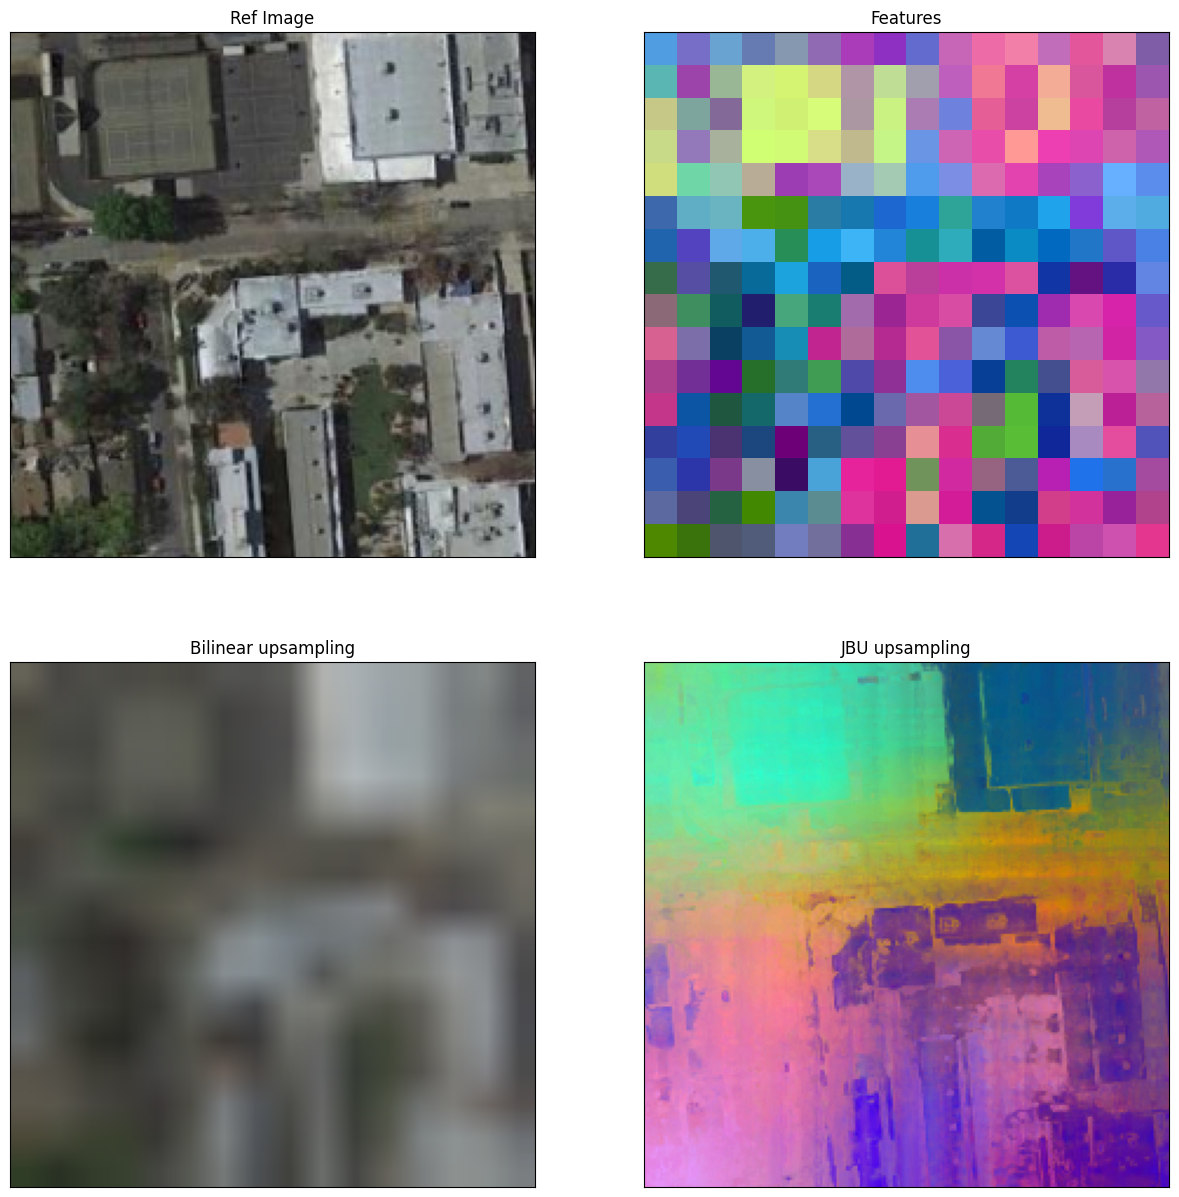

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax[0,0].imshow(image)
ax[0,0].set_title("Ref Image")
ax[0,1].imshow(lr_feat_pca_img)
ax[0,1].set_title("Features")
ax[1,0].imshow(small_img.resize(image.size, Image.BILINEAR))
ax[1,0].set_title("Bilinear upsampling")
ax[1,1].imshow(hr_feat_pca_img)
ax[1,1].set_title("JBU upsampling")
remove_axes(ax)
plt.show()